## Using Efficient Deep Learning to Classifying Disease Severity of COVID-19 Patients by using Saudi  X-ray Chest Images 

Image classification of Chest X Rays in one of three classes: Normal, Viral Pneumonia, COVID-19

Dataset from [COVID-19 Radiography Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) on Kaggle

# Importing Libraries

In [1]:
!pip install --user torchvision

In [2]:
%matplotlib inline
import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.6.0


# Preparing Training and Test Sets

In [3]:
class_names = ['normal', 'viral', 'covid']
root_dir = 'COVID_19_Radiography_Database'
source_dirs = ['NORMAL', 'Viral_Pneumonia', 'COVID_19']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

# Creating Custom Dataset

In [4]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x[-3:].lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

# Image Transformations

In [5]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Prepare DataLoader

In [6]:
train_dirs = {
    'normal': '/ibex/scratch/alsaedsb/COVID_19/DATASETS/COVID_19_Radiography_Database/NORMAL',
    'viral': '/ibex/scratch/alsaedsb/COVID_19/DATASETS/COVID_19_Radiography_Database/Viral_Pneumonia',
    'covid': '/ibex/scratch/alsaedsb/COVID_19/DATASETS/COVID_19_Radiography_Database/COVID_19'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 1341 normal examples
Found 1345 viral examples
Found 219 covid examples


In [7]:
test_dirs = {
    'normal': '/ibex/scratch/alsaedsb/COVID_19/DATASETS/COVID_19_Radiography_Database/NORMAL',
    'viral': '/ibex/scratch/alsaedsb/COVID_19/DATASETS/COVID_19_Radiography_Database/Viral_Pneumonia',
    'covid': '/ibex/scratch/alsaedsb/COVID_19/DATASETS/COVID_19_Radiography_Database/COVID_19'
}

test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 1341 normal examples
Found 1345 viral examples
Found 219 covid examples


In [8]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 485
Number of test batches 485


# Data Visualization

In [9]:
class_names = train_dataset.class_names


def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

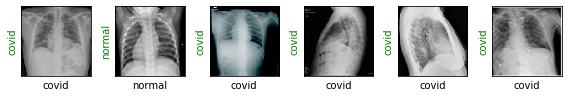

In [10]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

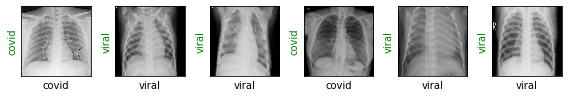

In [11]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

# Creating the Model

In [12]:
densenet161 = torchvision.models.densenet161(pretrained=True)

print(densenet161)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [13]:
densenet161.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(densenet161.parameters(), lr=3e-5)

In [14]:
def show_preds():
    densenet161.eval()
    images, labels = next(iter(dl_test))
    outputs = densenet161(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

# Training the Model

In [16]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        densenet161.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = densenet161(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                densenet161.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = densenet161(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                #show_preds()

                densenet161.train()

                if accuracy >= 0.95:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

In [17]:
%%time

train(epochs=1)

Starting training..
Starting epoch 1/1
Evaluating at step 0
Validation Loss: 8.9908, Accuracy: 0.0017
Evaluating at step 20
Validation Loss: 4.0773, Accuracy: 0.3518
Evaluating at step 40
Validation Loss: 2.0600, Accuracy: 0.7071
Evaluating at step 60
Validation Loss: 0.9888, Accuracy: 0.8640
Evaluating at step 80
Validation Loss: 0.9484, Accuracy: 0.8792
Evaluating at step 100
Validation Loss: 0.5413, Accuracy: 0.9236
Evaluating at step 120
Validation Loss: 0.3738, Accuracy: 0.9425
Evaluating at step 140
Validation Loss: 0.2436, Accuracy: 0.9611
Performance condition satisfied, stopping..
CPU times: user 1h 46min 57s, sys: 1min 24s, total: 1h 48min 21s
Wall time: 4h 23min 55s
